# Análise da clusterização temporal

## Imports, definição de funções e carregamento dos dados

In [1]:
from b_limpar.limpador import Limpador
from b_vetorizar.vetorizador import Vetorizador
from d_clusterizar_por_tempo import clusterizador_temporal
from c_clusterizar_por_texto.clusterizador_textual import ClusterizadorTextual
from _common import util
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

def gerar_grafico_kde(resultado_kde):
    plt.plot(resultado_kde['eixo_x'], resultado_kde['eixo_y'])
    for m in resultado_kde['minimos_locais']:
        plt.plot(resultado_kde['eixo_x'][m],resultado_kde['eixo_y'][m],'go')

def converter_datas_para_segundos(datas_str):
    f = '%Y-%m-%d %H:%M:%S'
    datas = []
    for d in datas_str:
        datas.append(datetime.strptime(d, f))
    datas_as_seconds = np.array([(d-datas[0]).total_seconds() for d in datas])
    return datas_as_seconds

noticias_df = util.carregar_todas_as_noticias() 
Limpador().limpar_se_necessario(noticias_df)
Vetorizador().vetorizar_word2vec(noticias_df, usar_texto_limpo=True, incluir_resumo=False)
ClusterizadorTextual().clusterizar(noticias_df, epsilon = 0.13, min_samples=4, metric='cosine')
clusterizador = clusterizador_temporal.ClusterizadorTemporal()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Edson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Limpando titulo
Limpando resumo
Baixando modelo Word2Vec
Carregando modelo Word2Vec
Vetorizando com Word2Vec


## Escolha do hiperparâmetro bandwidth

Como não se tem ideia do bandwidth adequado para o algoritmo, será usada uma fração da diferença entre a maior e a menor data. Será buscado na célula abaixo um denominador entre 1 e 100. Foram escolhidas algumas datas/horas de exemplo, que devem ser separadas razoavelmente em 4 clusters, visto que duas dessas datas/horas encontram-se no mesmo dia, devendo ser agrupadas juntas. 

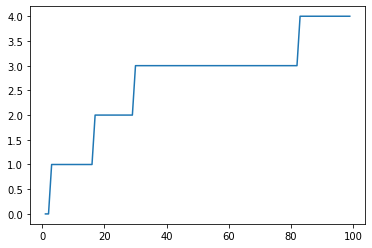

In [17]:
datas_as_seconds = converter_datas_para_segundos([
    '2022-09-17 11:20:25',
    '2022-09-17 19:50:55',
    '2022-09-19 18:40:30',
    '2022-09-29 10:00:20',
    '2022-09-30 14:05:10',
    '2022-09-30 15:10:35'])

num_minimos_locais_por_i = {}
for i in range(1, 100, 1):
    resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=i)
    num_minimos_locais_por_i.update({i: len(resultado_kde['minimos_locais'])})

plt.plot(list(num_minimos_locais_por_i.keys()), list(num_minimos_locais_por_i.values()))

Pelo gráfico, percebe-se que o valor 3 para a quantidade de mínimos locais (o que gerará 4 clusters) é alcançado para o denominador grosseiramente entre 30 e 80. Será escolhido então o valor médio de 55 para o denominador. Segue o resultado do KDE para esse valor. Os pontos verdes são os 3 mínimos locais que delimitarão os 4 clusters.

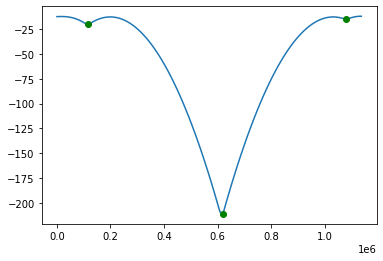

In [19]:
resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=55)
gerar_grafico_kde(resultado_kde)

Aplicando agora esse valor para outro conjunto de datas/horas, todas no mesmo dia. Esperam-se neste caso também 4 clusters, visto que duas datas encontram-se muito próximas, com intervalo de apenas 10 minutos:

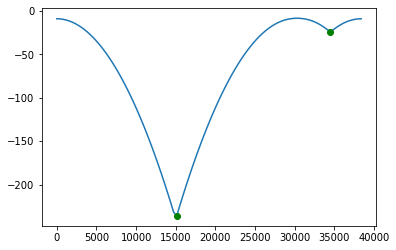

In [20]:
datas_as_seconds = converter_datas_para_segundos([
    '2022-09-17 07:20:25',
    '2022-09-17 15:40:30',
    '2022-09-17 15:50:55',
    '2022-09-17 18:00:20'])

resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=55)
gerar_grafico_kde(resultado_kde)

Conforme visto, também nessa situação o denominador escolhido resultou no número esperado de clusters.

## Visualização dos clusters

A célula abaixo salva no arquivo resultado_clusterizacao_temporal.json (e também exibe no output) as notícias clusterizadas pelo texto e pelo tempo. 

In [4]:
assuntos = clusterizador.clusterizar(noticias_df, denominador_bandwidth=55)
for assunto in assuntos:
    for subcluster in assunto['subclusters']:
        subcluster['evento']['data_publ'] = subcluster['evento']['data_publ'].isoformat()
assuntos_as_json = json.dumps(assuntos, indent=4)
with open("resultado_clusterizacao_temporal.json", "w") as outfile:
    outfile.write(assuntos_as_json)
assuntos

[{'id': 0,
  'subclusters': [{'evento': {'id': '1458084 at https://agenciabrasil.ebc.com.br',
     'fonte': 'Agência Brasil (Política)',
     'titulo': 'Câmara aprova piso salarial para enfermeiros',
     'resumo': '<p>A Câmara dos Deputados aprovou nesta quarta-feira (4), por 449 favoráveis e 12 contrários, o projeto de lei \xa0que institui piso salarial para enfermeiros, técnicos e auxiliares de enfermagem e parteiras. Oriundo do Senado, a matéria segue para sanção presidencial.<img src="https://agenciabrasil.ebc.com.br/ebc.png?id=1458084&amp;o=rss" style="width: 1px; height: 1px; display: inline;" /><img src="https://agenciabrasil.ebc.com.br/ebc.gif?id=1458084&amp;o=rss" style="width: 1px; height: 1px; display: inline;" /></p>\n\n<p>Pelo texto, o valor mínimo inicial para os enfermeiros será de R$ 4.750, a ser pago nacionalmente tanto em hospitais públicos e quanto em privados. Nos demais casos, o piso será proporcional: 70% do piso dos enfermeiros para os técnicos de enfermagem e 5